# В данной работе выполнен анализ данных фондового рынка России за 2018 год.

# Подготовка

На данном этапе производится импорт необходимых библиотек для работы с финансовыми данными, их статистического анализа и визуализации. Мы загружаем данные с таких источников, как Yahoo Finance и Московская биржа, и готовим их для последующего анализа. Использование переменных окружения через `dotenv` обеспечивает безопасность доступа к API. В дальнейшем данные будут анализироваться с помощью статистических методов, таких как тесты на нормальность, автокорреляция и подгонка распределений.

In [ ]:
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from moexalgo import Ticker, session
from dotenv import load_dotenv
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import seaborn as sns
import os
from distfit import distfit

load_dotenv()


def initialize_session(username, password):
    session.authorize(username, password)

# Сбор информации по росскийскому фондовому рынку

На данном этапе производится сбор информации о рыночной капитализации и секторах компаний с Московской биржи (MOEX) с использованием данных из Yahoo Finance. Для каждого тикера мы извлекаем данные о рыночной капитализации и секторе компании.


In [ ]:
def get_moex_info(tickers):
    market_info = {}
    c = 0

    for ticker in tickers:
        try:
            yf_ticker = yf.Ticker(f"{ticker}.ME")
            info = yf_ticker.info

            market_cap = info.get('marketCap', 0)
            sector = info.get('sector', 'Unknown')

            market_info[ticker] = {
                'marketCap': market_cap,
                'sector': sector
            }
        except Exception as e:
            print(f"Error fetching market cap or sector for {ticker}: {e}")
            market_info[ticker] = {
                'marketCap': 0,
                'sector': 'Unknown'
            }

        c += 1
        if c % 10 == 0:
            print(f"Processed {c} tickers")

    sorted_market_caps = sorted(market_info.items(), key=lambda x: x[1]['marketCap'], reverse=True)

    return len(tickers), sorted_market_caps

# Получение цен активов

Функция `get_moex_tickers()` запрашивает список всех доступных тикеров на Московской бирже через API MOEX. Этот список включает все акции, торгующиеся на площадке, и он используется для дальнейшего сбора данных о ценах.

Функция `fetch_data_for_tickers()` загружает исторические данные о ценах на основе списка тикеров с использованием предоставленного периода и диапазона дат. Она использует API MOEX для получения данных о свечах (candlestick) по каждому тикеру. 

In [ ]:
def get_moex_tickers():
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json"
    response = requests.get(url)
    data = response.json()
    tickers = [item[0] for item in data['securities']['data']]
    return tickers


def fetch_data_for_tickers(tickers, start_date='2018-01-01', end_date='2018-12-31', period=24):
    price_data_list = []
    ticker_names = []

    for ticker in tickers:
        try:
            moex_ticker = Ticker(ticker)
            candles = moex_ticker.candles(start=start_date, end=end_date, period=period)

            if candles.empty:
                print(f"No data available for {ticker} in the specified date range.")
            else:
                price_data_list.append(candles['close'].reset_index(drop=True))
                ticker_names.append(ticker)
                print(f"Data for {ticker} fetched successfully.")
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    price_data = pd.concat(price_data_list, axis=1)
    price_data.columns = ticker_names
    return price_data

На выходе получаем следующий датасет:

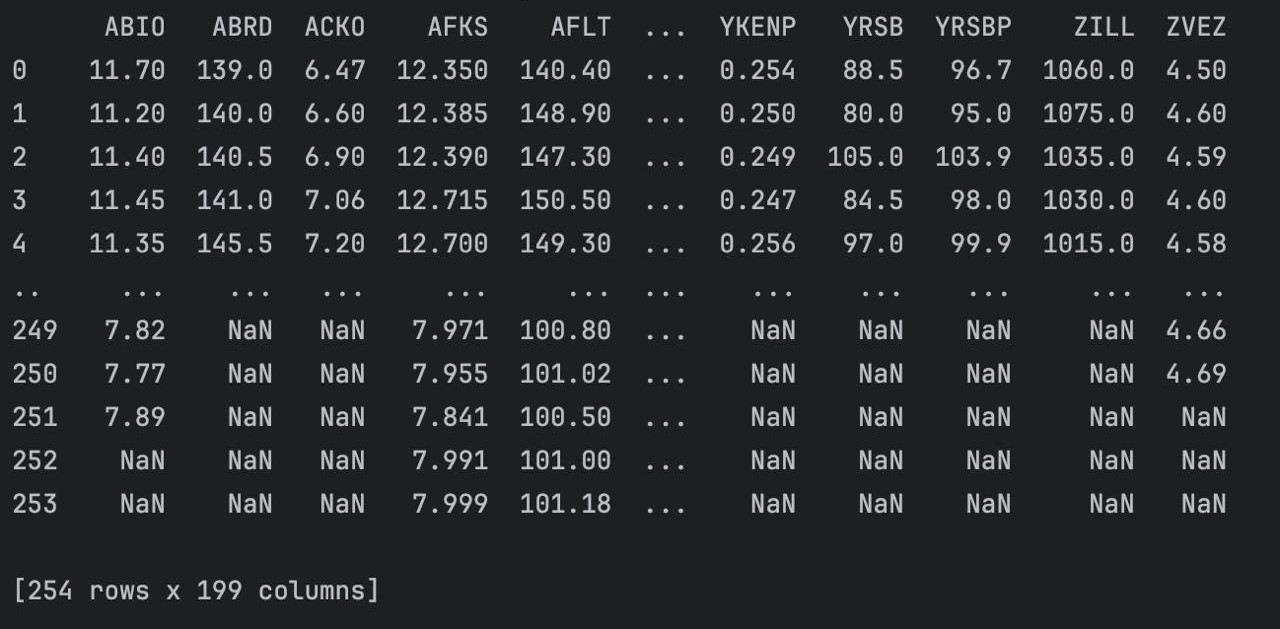

# Подсчет логарифмической доходности:

Вычисляем логарифмические доходности для каждого тикера на основе исторических данных о ценах. Логарифмическая доходность является важной характеристикой временных рядов финансовых данных, поскольку она позволяет учитывать процентные изменения между последовательными значениями цены. Рассчитывается как разность натуральных логарифмов цен активов.

In [ ]:
def calculate_log_returns(price_data):
    if price_data.empty:
        print("No price data available for any tickers.")
        return pd.DataFrame()

    log_returns = np.log(price_data / price_data.shift(1))

    return log_returns

# Вычисление ожидаемой доходности (мат. ожидание) и стандартного отклонения для каждого тикера


Получаем два ключевых статистических показателя для логарифмических доходностей: средние доходности и стандартные отклонения для каждого тикера. 



In [ ]:
def calculate_statistics(log_returns):
    if log_returns.empty:
        print("No log returns available for calculation.")
        return pd.Series(), pd.Series()

    mean_returns = log_returns.mean()
    std_devs = log_returns.std()
    return mean_returns, std_devs

# Поиск Парето - оптимальных активов

Идентифицируем Парето-оптимальные активы на основе их средних доходностей и стандартных отклонений. Парето-оптимальный актив — это такой актив, для которого не существует другого актива с более высокой доходностью и меньшей волатильностью одновременно.

- Актив считается **Парето-оптимальным**, если его доходность нельзя улучшить без увеличения риска (волатильности).
- Функция проходит по каждому активу и проверяет, существует ли другой актив с более высокой доходностью и меньшим риском. Если такой актив существует, текущий актив исключается из множества Парето-оптимальных.


In [ ]:
def find_pareto_optimal(mean_returns, std_devs):
    is_pareto_optimal = np.ones(mean_returns.shape[0], dtype=bool)
    for i, (mean_i, std_i) in enumerate(zip(mean_returns, std_devs)):
        for j, (mean_j, std_j) in enumerate(zip(mean_returns, std_devs)):
            if i != j:
                if (mean_j > mean_i) and (std_j < std_i):
                    is_pareto_optimal[i] = False
                    break
    return is_pareto_optimal

# Отрисовка графика

Создаем визуализацию активов на координатной плоскости с осями, представляющими стандартное отклонение (риск) и среднюю доходность (ожидаемая прибыль) для каждого актива. Это важный шаг для анализа соотношения "риск-доходность" активов.

- **Стандартное отклонение** отображается по оси X.
- **Средняя доходность** отображается по оси Y.
- **Парето-оптимальные активы** визуализируются в отдельном цвете.

In [ ]:
def plot_asset_map_with_pareto(mean_returns, std_devs, pareto_optimal, most_preferred_var_index, output_dir='plots'):
    if mean_returns.empty or std_devs.empty:
        print("Insufficient data for plotting the asset map.")
        return

    plt.figure(figsize=(18, 10))
    plt.scatter(std_devs, mean_returns, c='blue', marker='o', label="Assets", alpha=0.7)

    plt.scatter(std_devs[pareto_optimal], mean_returns[pareto_optimal], c='red', marker='o', label="Pareto Optimal", alpha=0.9)

    plt.scatter(std_devs_optimal[most_preferred_var_index], mean_returns_optimal[most_preferred_var_index], c='green', marker='o', label="Most Preferred", alpha=0.9)

    for i, ticker in enumerate(mean_returns.index):
        if pareto_optimal[i]:
            plt.annotate(ticker, (std_devs[i], mean_returns[i]), fontsize=12)

    plt.xlim(0, 0.1)
    plt.ylim(-0.005, 0.01)

    plt.title('Asset Map (σ, E) with Pareto Optimal Assets')
    plt.xlabel('Standard Deviation (Risk)')
    plt.ylabel('Mean Return')
    plt.legend()
    plt.grid(True)
    filepath = os.path.join(output_dir, "Asset_map.png")
    plt.savefig(filepath)
    print(f"График Asset Map сохранен в {filepath}")
    plt.show()

# Нахождение var и cvar по формуле:

- **Value at Risk (VaR)**: Функция `calculate_var()` вычисляет показатель VaR, который оценивает максимальный потенциальный убыток актива за определенный период времени с заданным уровнем доверия (95%).
  
- **Conditional Value at Risk (CVaR)**: Функция `calculate_cvar()` рассчитывает показатель CVaR, который является средним убытком в худших сценариях, превышающих значение VaR.

- **Оптимизация активов**: Функция `optimal()` фильтрует только Парето-оптимальные активы и возвращает их средние доходности, тикеры и стандартные отклонения.

- **Индексы VaR и CVaR**: Функция `var_and_cvar_index()` возвращает индексы активов с минимальными значениями VaR и CVaR среди Парето-оптимальных активов.

In [ ]:
def calculate_var(returns, confidence_level=0.95):
    return -np.percentile(returns, (1 - confidence_level) * 100)


def calculate_cvar(returns, confidence_level=0.95):
    return -np.mean(returns[returns <= -calculate_var(returns, confidence_level)])


def optimal(pareto_optimal, mean_returns, tickers, std_devs):
    mean_returns_optimal = []
    tickers_optimal = []
    std_devs_optimal = []
    for i in range(0, len(pareto_optimal)):
        if pareto_optimal[i] and not np.isnan(mean_returns[i]):
            mean_returns_optimal.append(mean_returns[i])
            tickers_optimal.append(tickers[i])
            std_devs_optimal.append(std_devs[i])
    return mean_returns_optimal, tickers_optimal, std_devs_optimal


def var_and_cvar_index(pareto_optimal, mean_returns):
    var = []
    cvar = []
    for i in range(0, len(pareto_optimal)):
        if pareto_optimal[i] and not np.isnan(mean_returns[i]):
            var.append(calculate_var(mean_returns[i], 0.95))
            cvar.append(calculate_cvar(mean_returns[i], 0.95))
    var = np.array(var)
    cvar = np.array(cvar)
    return np.argmin(var), np.argmin(cvar)

## Актив с наиболее предпочтительным var :

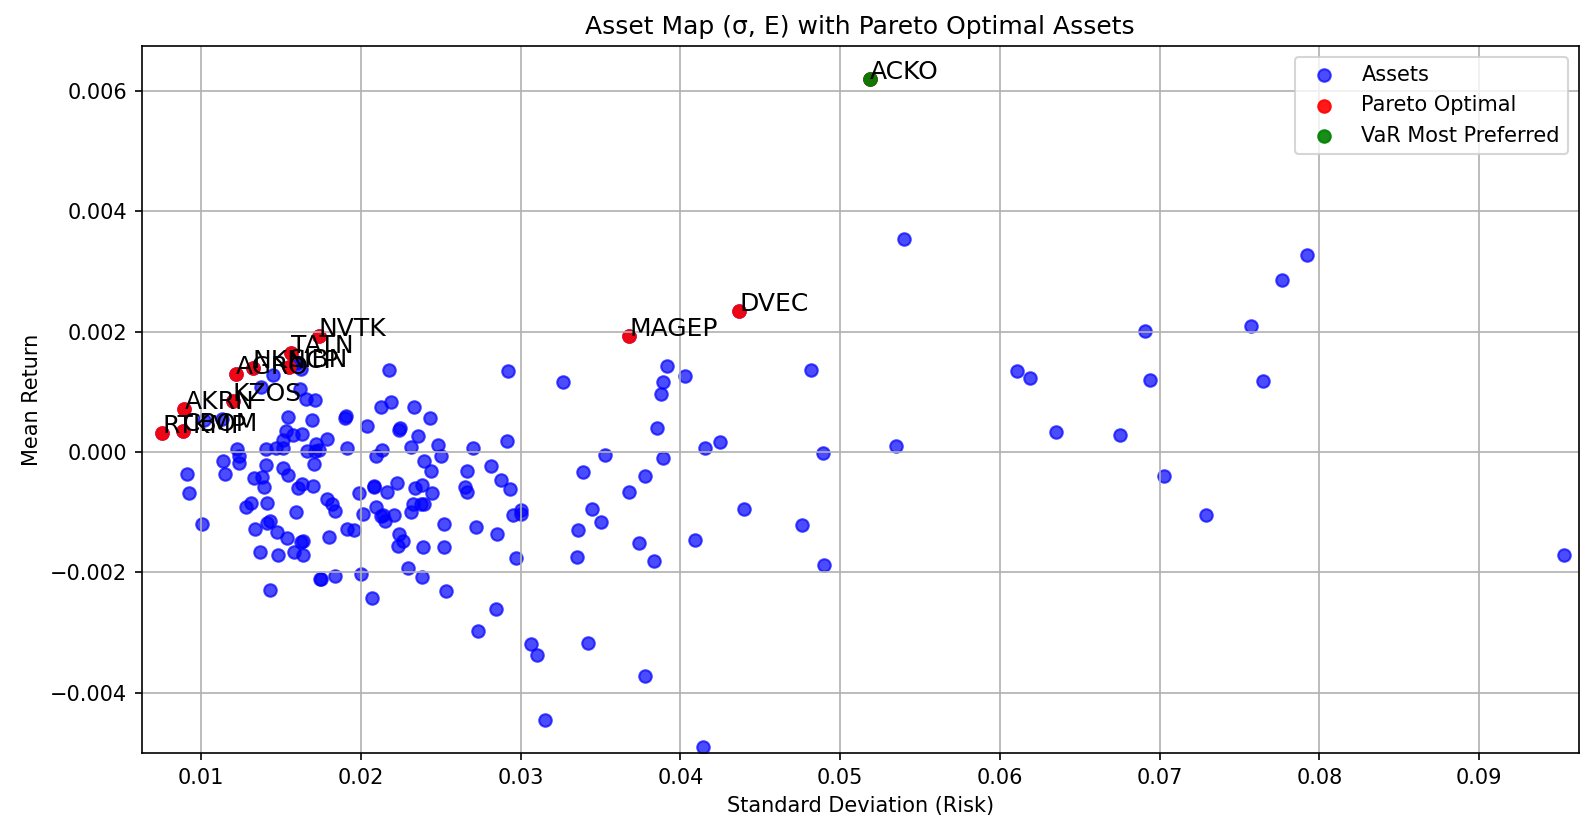

## Актив с наиболее предпочтительным cvar :

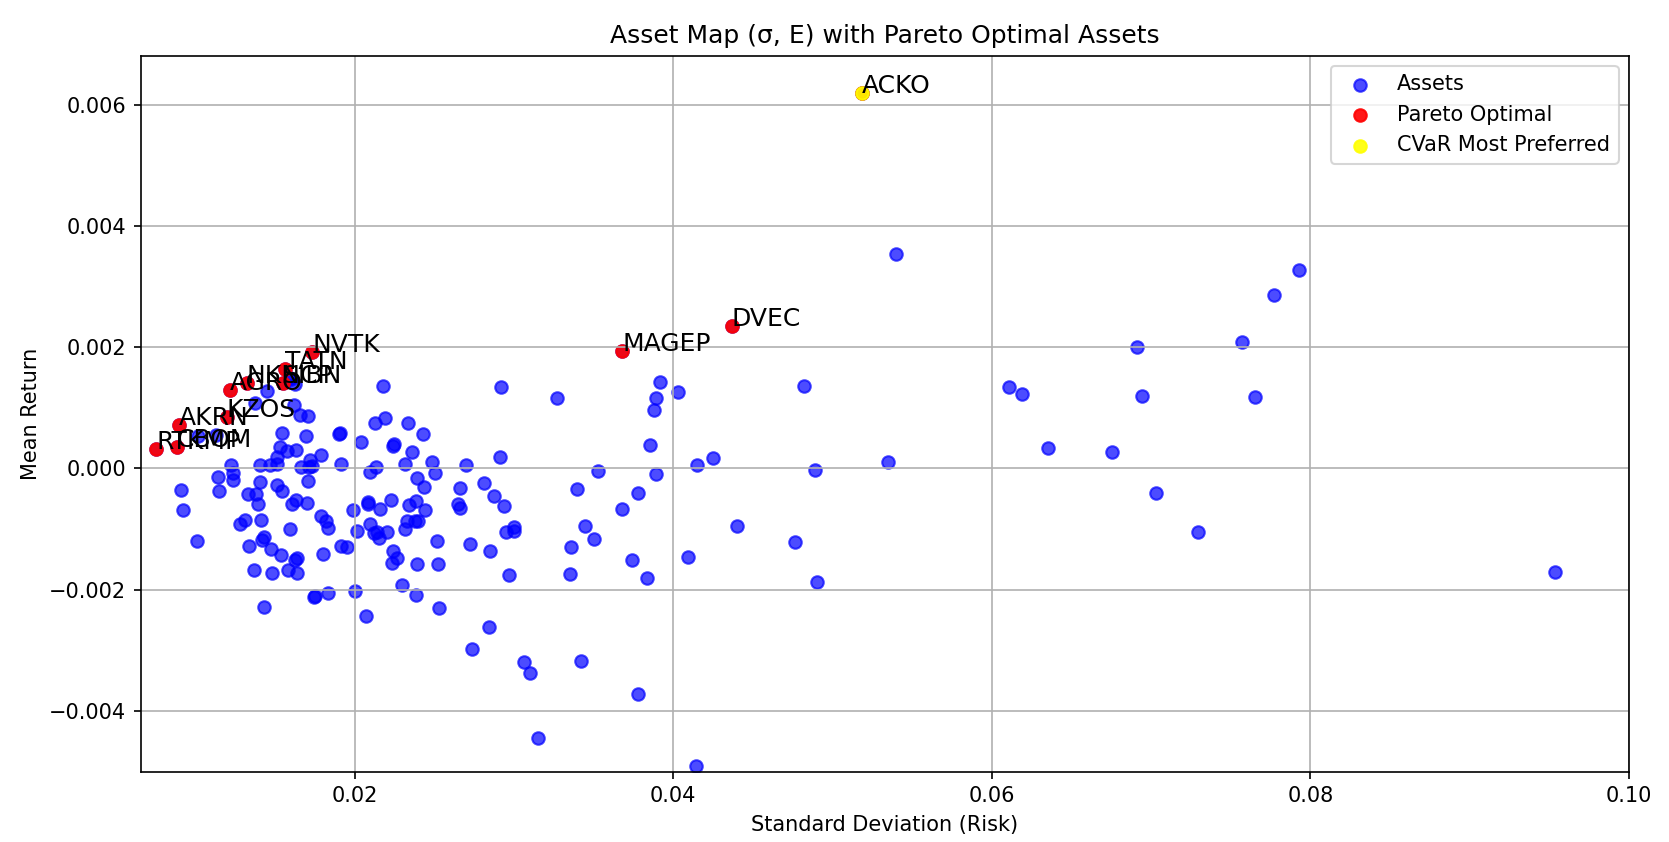

# Проверка автокорреляции (белого шума)

Автокорреляция позволяет оценить, как текущие значения активов зависят от их прошлых значений.

1. **Функция `plot_acf_for_assets()`**:
   Строим графики автокорреляционной функции (ACF) для каждого актива, на основе его логарифмических доходностей. ACF помогает выявить наличие зависимости между значениями временного ряда на разных временных отрезках (лагами). 

2. **Функция `test_white_noise()`**:
   Используем **тест Льюнга-Бокса**, чтобы проверить, являются ли данные временного ряда "белым шумом", т.е. не содержат ли они автокорреляций. 
   
   - **Белый шум** предполагает, что значения временного ряда не имеют значимой автокорреляции, а их последовательность случайна. 
   - Функция применяет тест Льюнга-Бокса, который проверяет наличие автокорреляций на заданных лагах.


In [ ]:
def plot_acf_for_assets(log_returns, lags=40, output_dir='plots'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for ticker in log_returns.columns:
        returns = log_returns[ticker].dropna()
        if returns.empty or len(returns) < lags:
            print(f"Недостаточно данных для ACF графика для {ticker}. Пропущено.")
            continue

        plt.figure(figsize=(10, 6))
        plot_acf(returns, lags=lags, alpha=0.05)
        plt.title(f"ACF для {ticker}")

        filepath = os.path.join(output_dir, f"ACF_{ticker}.png")
        plt.savefig(filepath)
        plt.close()
        print(f"График ACF для {ticker} сохранен в {filepath}")


def test_white_noise(log_returns, max_lags=None):
    results = {}

    for ticker in log_returns.columns:
        returns = log_returns[ticker].dropna()
        if returns.empty or len(returns) < (max_lags or 10):
            print(f"Недостаточно данных для теста белого шума для {ticker}. Пропущено.")
            results[ticker] = "Недостаточно данных"
            continue

        n_obs = len(returns)
        lags = max_lags if max_lags else int(np.sqrt(n_obs))
        lags = min(lags, len(returns) - 1)
        print(ticker, lags)

        try:
            lb_test = acorr_ljungbox(returns, lags=[lags], return_df=True)
            p_value = lb_test['lb_pvalue'].values[0]
            if p_value > 0.05:
                results[ticker] = "Белый шум (случайность не отвергается)"
            else:
                results[ticker] = "Не белый шум (случайность отвергается)"
        except ValueError as e:
            print(f"Ошибка для {ticker}: {e}")
            results[ticker] = "Ошибка в данных"

    return results

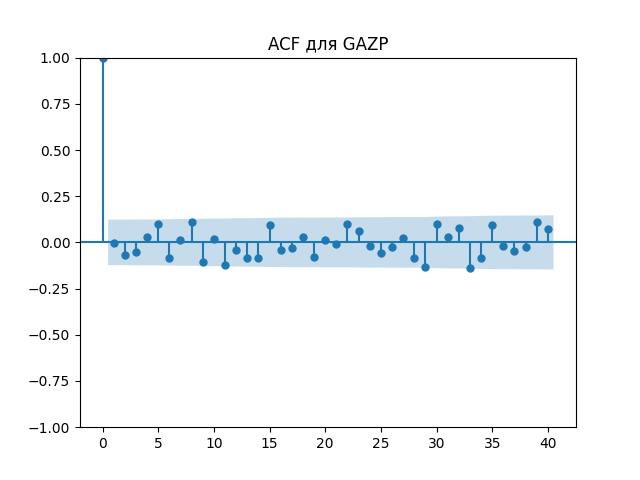


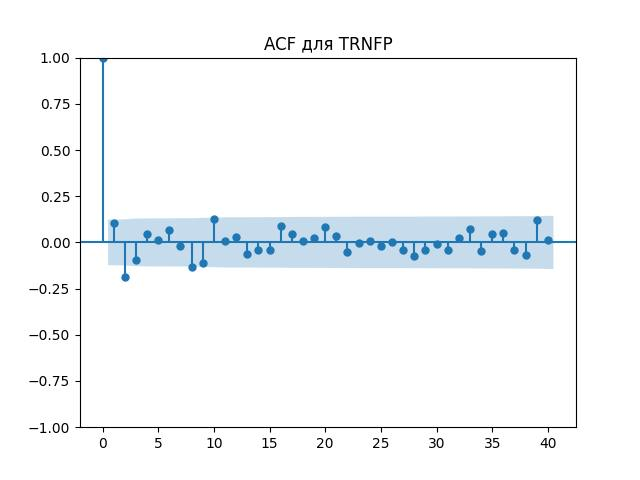

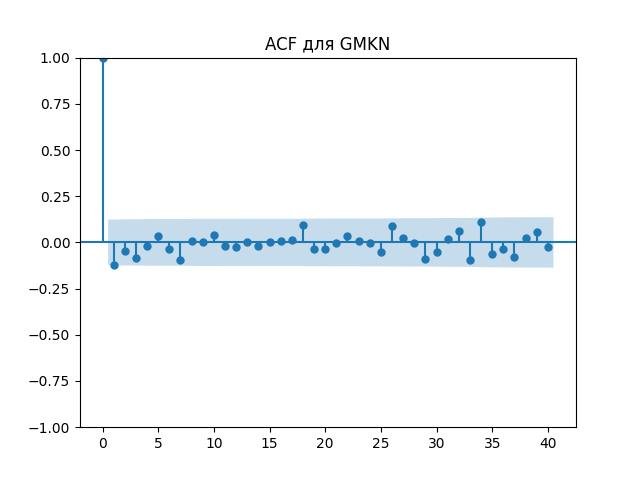


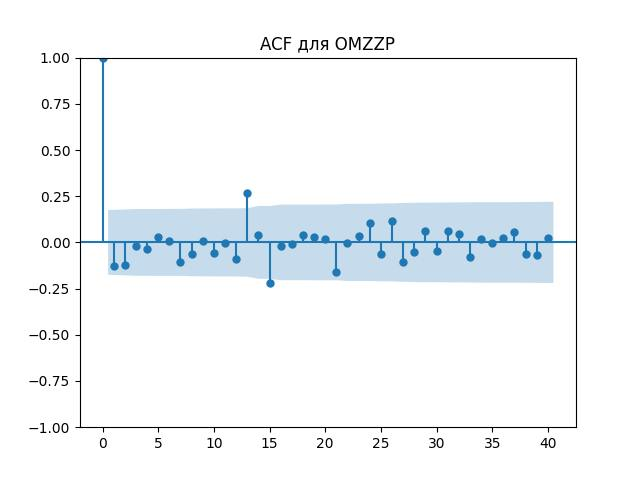

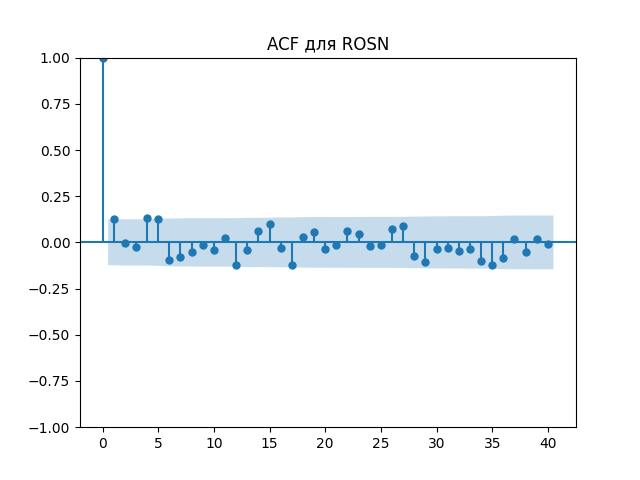

# Анализ нормальности распределения доходностей:

1. **Функция `analyze_normality()`**:
   Эта функция анализирует, подчиняются ли доходности выбранных активов нормальному распределению. Для этого используются два ключевых статистических теста:
   
   - **Тест Шапиро-Уилка** проверяет гипотезу о нормальности данных. Он чувствителен к отклонениям от нормального распределения, особенно для небольших выборок.
   - **Тест Колмогорова-Смирнова (K-S тест)** сравнивает эмпирическое распределение данных с теоретическим нормальным распределением, используя среднее и стандартное отклонение логарифмических доходностей.

   Визуализация результатов включает:
   - **Гистограмма с оценкой плотности распределения (KDE)** для визуальной оценки формы распределения.
   - **Q-Q график** для проверки, насколько хорошо доходности соответствуют нормальному распределению.

   Если p-value больше 0.05 для обоих тестов, можно считать, что данные подчиняются нормальному распределению. В противном случае распределение отклоняется от нормального.

2. **Функция `find_top_assets_by_sector()`**:
   Эта функция выбирает 5 активов из различных секторов экономики. Она проходит по данным активов (с информацией о рыночной капитализации и секторе), отбирая только один актив из каждого уникального сектора.

In [ ]:
def analyze_normality(log_returns, selected_assets):
    output_dir = 'Distribution_analysis'

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for asset, info in selected_assets:
        ticker = asset
        returns = log_returns[ticker].dropna()

        shapiro_test = stats.shapiro(returns)
        kstest = stats.kstest(returns, 'norm', args=(returns.mean(), returns.std()))

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(returns, kde=True, color='blue', bins=30)
        plt.title(f"Гистограмма распределения доходностей для {ticker}")
        plt.subplot(1, 2, 2)
        stats.probplot(returns, dist="norm", plot=plt)
        plt.title(f"Q-Q график для {ticker}")
        plt.savefig(f"{output_dir}/Distribution_{ticker}.png")
        plt.close()

        print(f"\nРаспределение доходностей для {ticker}:")
        print(f"Тест Шапиро-Уилка: p-value = {shapiro_test.pvalue:.5f}")
        print(f"Тест Колмогорова-Смирнова: p-value = {kstest.pvalue:.5f}")
        if shapiro_test.pvalue > 0.05 and kstest.pvalue > 0.05:
            print(f"Распределение доходностей для {ticker} можно считать нормальным.\n")
        else:
            print(f"Распределение доходностей для {ticker} не является нормальным.\n")

In [ ]:
def find_top_assets_by_sector(moex_info, n=5):
    sectors_found = set()
    selected_assets = []

    for ticker, info in moex_info:
        sector = info['sector']
        if sector not in sectors_found:
            selected_assets.append((ticker, info))
            sectors_found.add(sector)
            if len(selected_assets) == n:
                break

    return selected_assets

# Проверка на другие распредления доходностей

Используем библиотеку `distfit` для подбора наилучшего вероятностного распределения для логарифмических доходностей выбранных активов. Библиотека автоматически подбирает распределение на основе данных, сравнивая их с различными теоретическими распределениями (например, нормальное, экспоненциальное, гамма и т.д.). 


In [ ]:
def analyze_distributions_distfit(log_returns, selected_assets):
    dist_fitter = distfit()

    for asset, info in selected_assets:
        returns = log_returns[asset].dropna()

        dist_fitter.fit_transform(returns)

        print(f"\nРезультаты для актива {asset}:")
        print(f"Лучшее распределение: {dist_fitter.model['name']}")

        dist_fitter.plot()
        plt.title(f"Распределение для {asset}")
        filepath = os.path.join('plots', f"Distribution_{ticker}.png")
        plt.savefig(filepath)
        print(f"График распределение для {ticker} сохранен в {filepath}")
        plt.show()

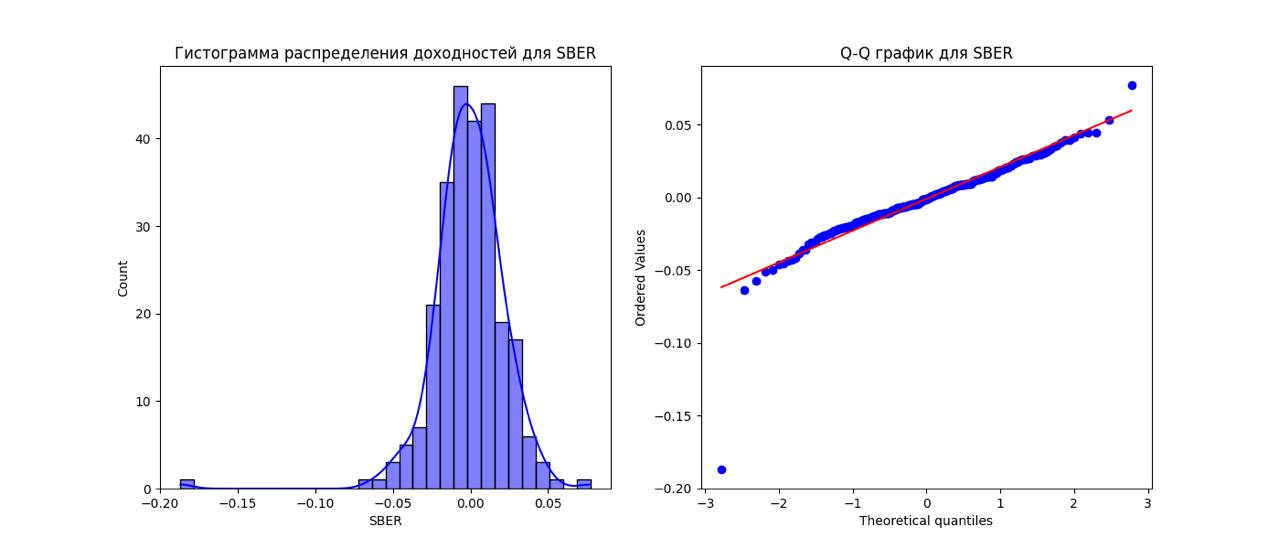


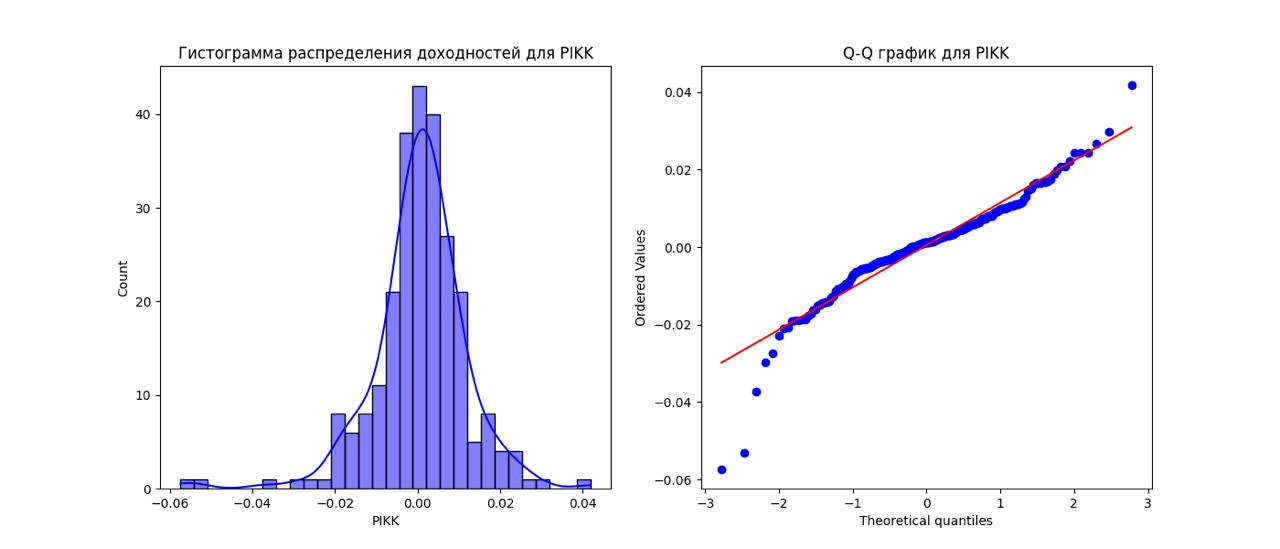


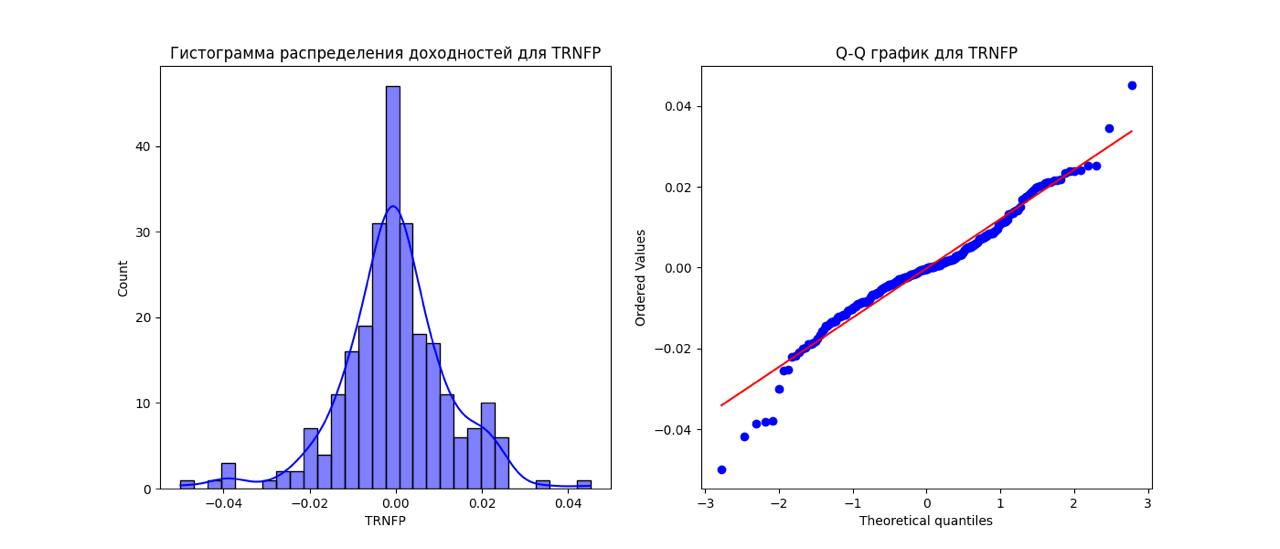


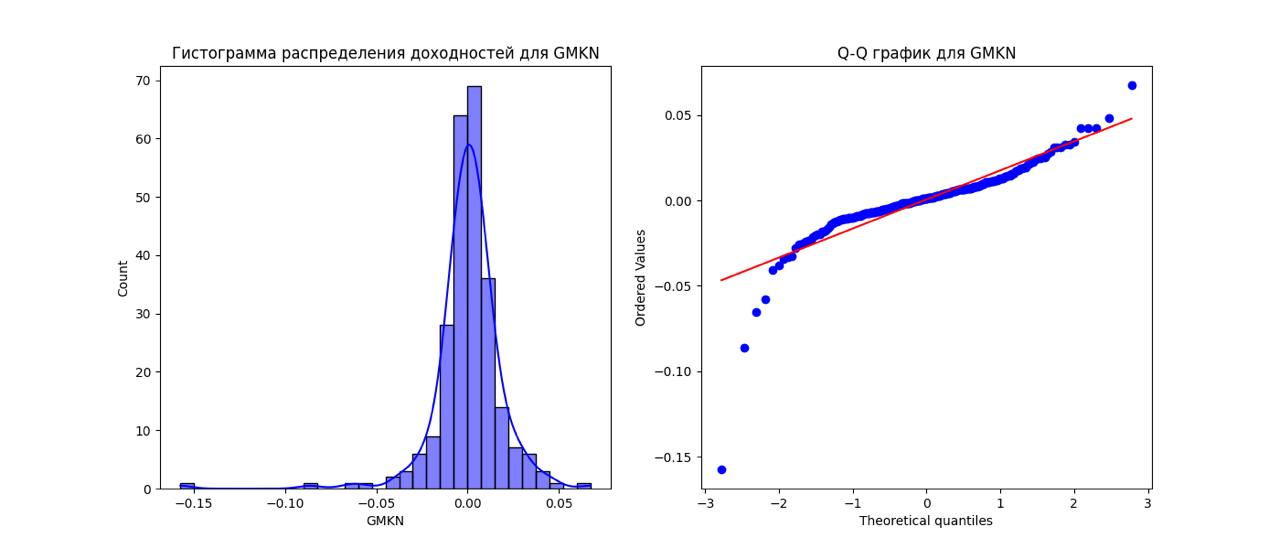


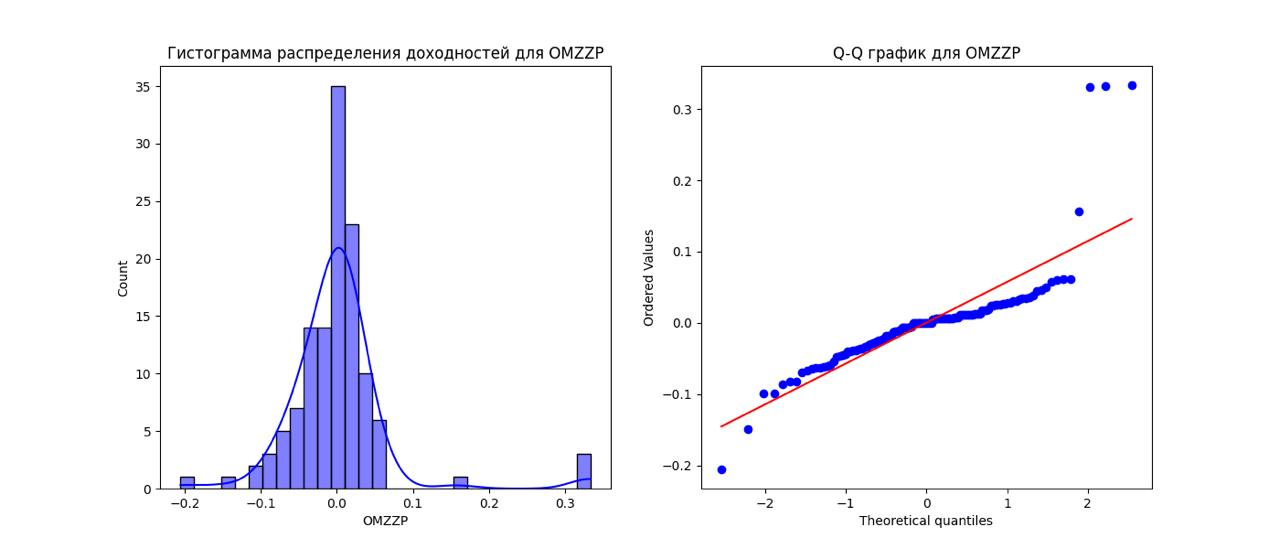


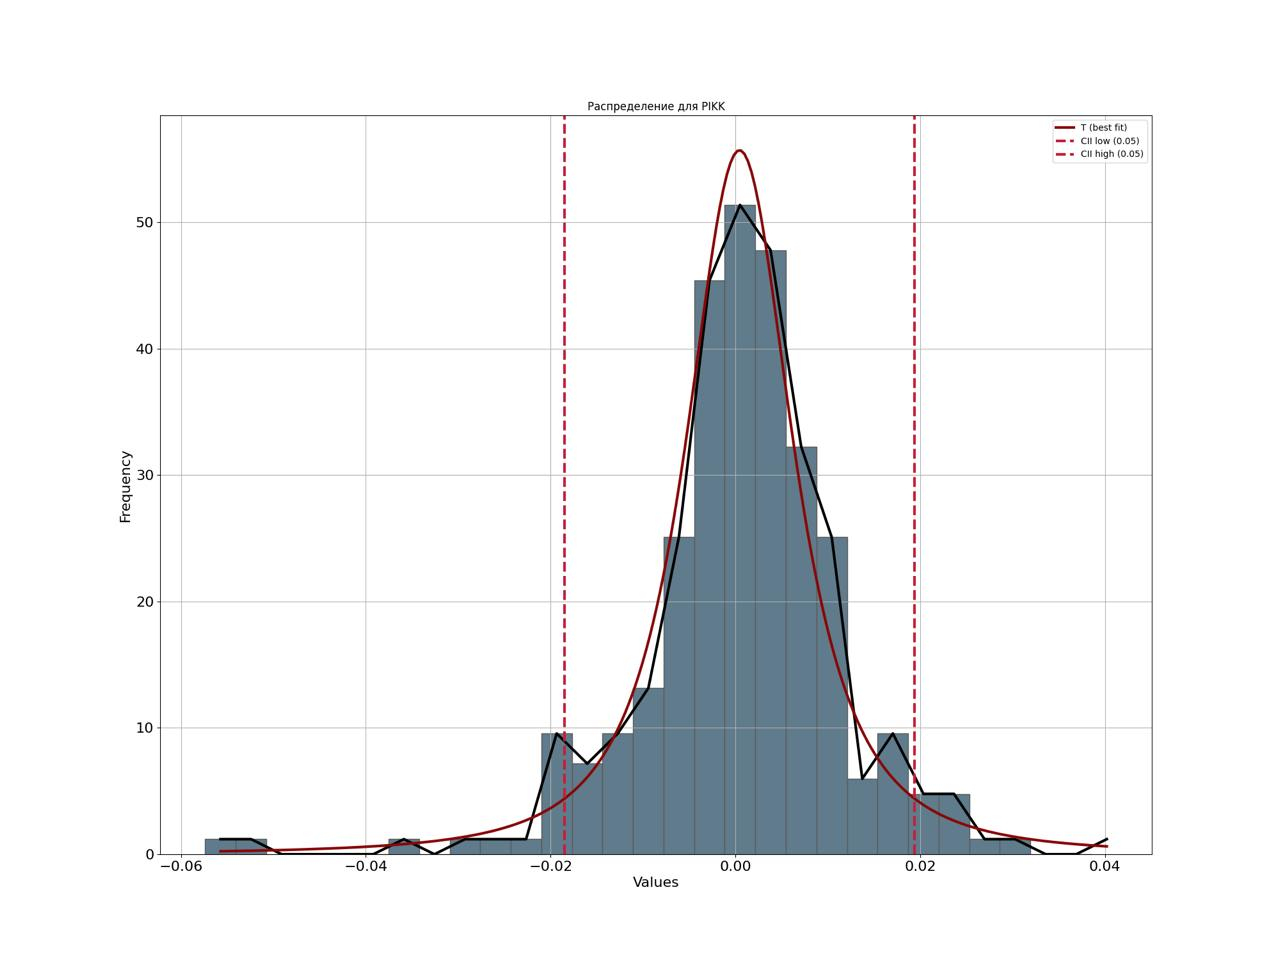


## Графики интересных акций:  

1. ACKO
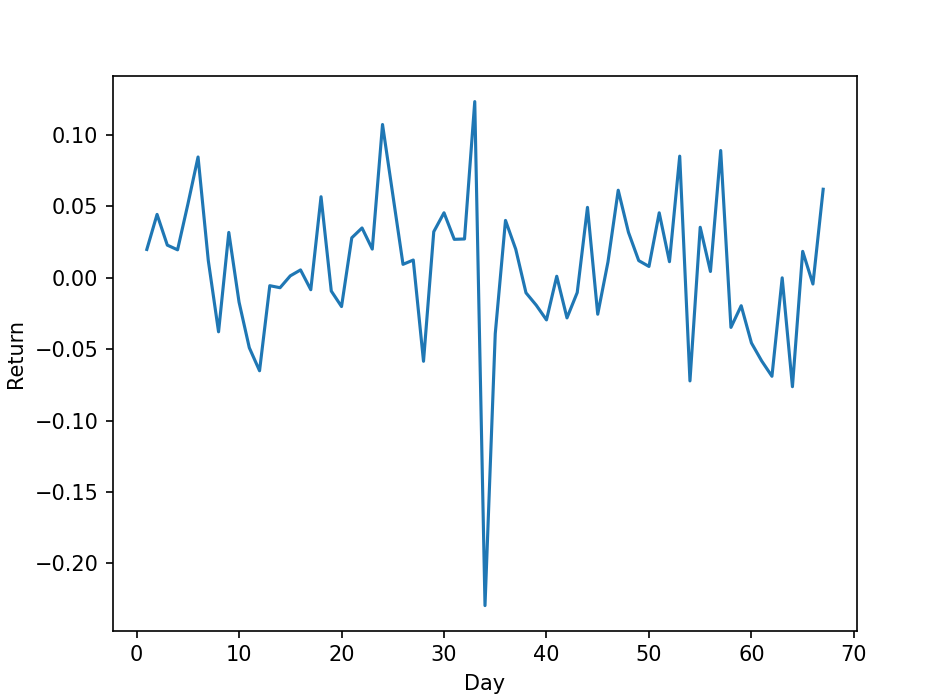

2. KOGK
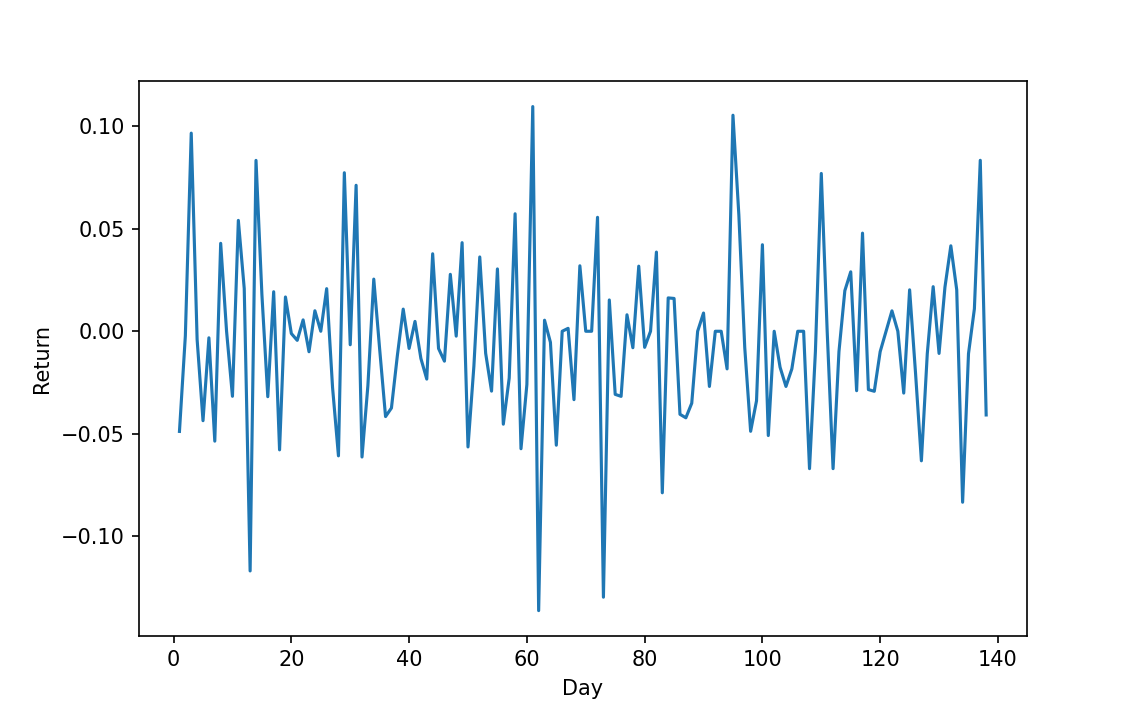

3. RUSI
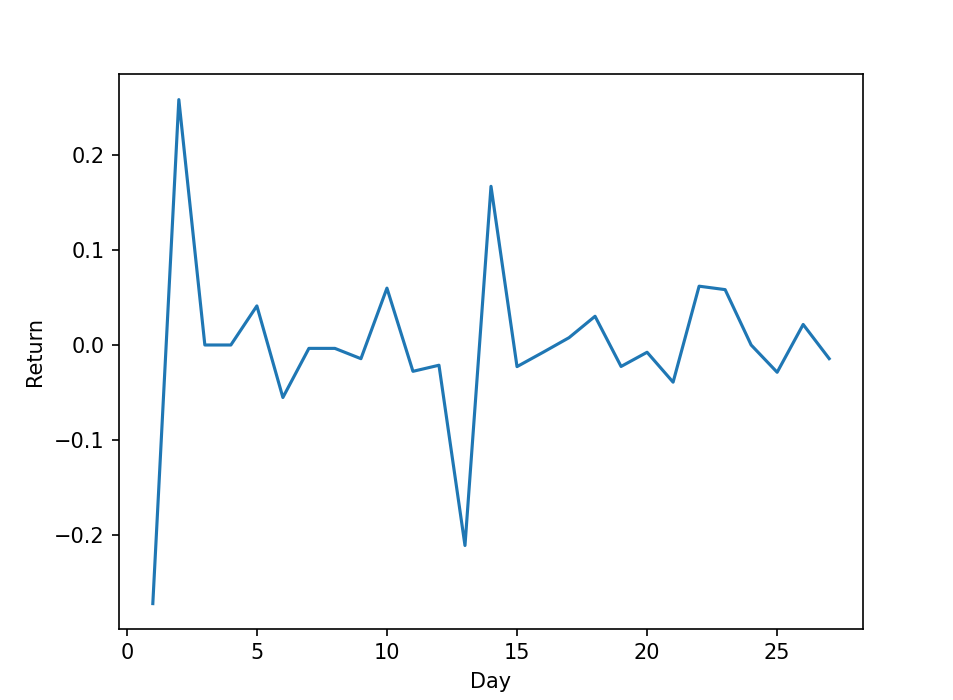